<a href="https://colab.research.google.com/github/carthy27/CS4287-CNNs-/blob/main/MyNotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

!pip install torch torchvision matplotlib

import tensorflow as tf
from torchvision import models, transforms
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Subset
import matplotlib.pyplot as plt
import time

In [ ]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((299, 299)),  # Resize images to 299x299 pixels, needed for Inception V3
    transforms.ToTensor(),  # Convertin images to tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Adjusting pixel values to between -1 and 1
])

#This is for resnet. Resnet performs better with 244x244 rather than the bigger image size.
resnet_transform = transforms.Compose([
    transforms.Resize(256),  # Resize the smaller side to 256, maintaining aspect ratio
    transforms.CenterCrop(224),  # Crop the center to 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

#todo Data Correlation and feature engineering if applicablec. Need to find iout if there is any in the dataset we have
#todo Any pre-processing such as normalisation applied to the dat explain what its doing in ours ^

# Load CIFAR-10 dataset
train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)
#Could be bias here if the images have something that is on the outside of the image as we are reducing size here.
train_dataset_resnet = CIFAR10(root='./data', train=True, download=True, transform=resnet_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
train_loader_resnet = DataLoader(train_dataset_resnet, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
#Batch size of 32 means less memory used compared to other values. Too high its too general. Too low u may develop a bias due to learning at very regular rates.
print("Dataset loaded.")
for images, labels in train_loader:
    print("Labels in the batch:", labels)
    break

for images, labels in train_loader_resnet:
    print("Labels in the batch_resnet:", labels)
    break

100%|██████████| 170M/170M [00:13<00:00, 13.1MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified
Dataset loaded.
Labels in the batch: tensor([2, 3, 4, 0, 8, 5, 4, 2, 8, 1, 4, 2, 3, 4, 1, 1, 2, 7, 6, 0, 8, 2, 5, 3,
        7, 1, 4, 7, 2, 5, 8, 6])
Labels in the batch_resnet: tensor([2, 7, 1, 4, 1, 9, 4, 6, 5, 6, 8, 1, 3, 4, 4, 8, 8, 6, 4, 7, 4, 9, 7, 9,
        1, 5, 9, 1, 1, 7, 9, 4])


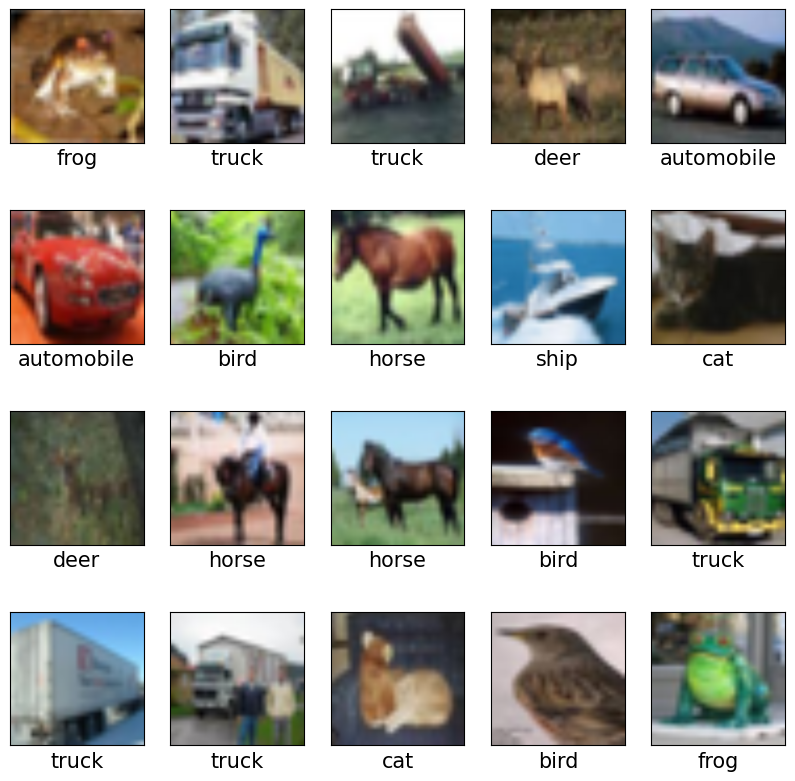

Number of samples: 50000


In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer','dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10, 10))
for i in range(20):
    plt.subplot(4, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    image = train_dataset[i][0]
    image = image / 2 + 0.5
    image_np = image.cpu().numpy().clip(0,1)
    plt.imshow(np.transpose(image_np, (1, 2, 0)))
    fontsize = 5
    fontsize = fontsize * (image_np.shape[1]/100)
    plt.xlabel(class_names[train_dataset[i][1]], fontsize=fontsize)
plt.show()
print("Number of samples:", len(train_dataset))

In [ ]:
#Setup for kfold validation.
k=5
kf = KFold(n_splits=k, shuffle=True, random_state=42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Load pre-trained Inception V3 moel

inception = models.inception_v3(weights='DEFAULT')
inception.fc = nn.Linear(2048, 10)  # Adjust final layer for 10 classes
print("Offload the work to the gpu ha")
inception = inception.cuda()

inception.aux_logits = False  # Disable auxiliary classifier to prevent errors during training
print("Loading InceptionV3 model")

print("Models loaded and customized for CIFAR-10.")


# Load Pre-Trained ResNet50

resnet = models.resnet50(weights='ResNet50_Weights.DEFAULT')

resnet = resnet.cuda()

resnet.fc = nn.Linear(2048, 10)  # Adjust final layer for 10 classes

print("Loading ResNet50")
print("Models loaded and customized for CIFAR-10.")
#todo define weight initilisation




Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 217MB/s]


Offload the work to the gpu ha
Loading InceptionV3 model
Models loaded and customized for CIFAR-10.


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 213MB/s]


Loading ResNet50
Models loaded and customized for CIFAR-10.


In [ ]:
from tqdm import tqdm

def train(model, loader, criterion, optimizer, epochs=10, verbose=2):
    model.train()  # Set the model to training mode

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(epochs):  # Loop over the specified number of epochs
        epoch_start = time.time()
        running_loss = 0.0  # Initialize a variable to accumulate the loss for the current epoch
        correct = 0
        total = 0

        with tqdm(loader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch", disable=verbose==0) as pbar:

           for inputs, labels in pbar:
            inputs, labels = inputs.cuda(), labels.cuda()  # Move inputs and labels to the GPU

            # Zero the parameter gradients to avoid accumulation from previous steps
            optimizer.zero_grad()

            # Forward pass: compute model predictions
            outputs = model(inputs)

            if isinstance(outputs, tuple):
              outputs = outputs[0]

            # Calculate the loss
            loss = criterion(outputs, labels)

            # Backward pass: compute gradients
            loss.backward()

            # Update model parameters using the computed gradients
            optimizer.step()

            # Accumulate the loss for this batch
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)  # Get class predictions
            correct += (predicted == labels).sum().item()
            total += labels.size(0)  # Count total samples

            pbar.set_postfix(loss=loss.item(), accuracy =100 * correct / total)

        epoch_loss = running_loss / len(loader)
        epoch_accuracy = 100 * correct / total
        epoch_time = time.time() - epoch_start

        if verbose >= 1:
              print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, Time: {epoch_time:.2f}s")

    if verbose == 0:
      print(f"Training complete after {epochs} epochs.")

    return epoch_accuracy

def evaluate(model, loader):
    model.eval()  # Set the model to evaluation mode

    #Initialize counters
    correct = 0
    total = 0

    with torch.no_grad():  # No need for backpropagate in eval
        for inputs, labels in loader:
            inputs, labels = inputs.cuda(), labels.cuda()

            # Forward pass
            outputs = model(inputs)

            # Get the predicted class by taking the index of the maximum output (i.e., the predicted class)
            _, predicted = torch.max(outputs.data, 1)

            # Update counters for total labels and correct predictions
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate accuracy as the percentage of correct predictions
    accuracy = 100 * correct / total
    print(f"Accuracy: {accuracy:.2f}%")

    return accuracy


K Fold Cross-Validation

Training and Evaluation
Inception V3

In [ ]:
#This block will train and evaluate V3
# Set the loss function.

optimizer_inception = optim.Adam(inception.parameters(), lr=0.001)
# Uses Adam optimizer for efficiency. adjusts LR based on graients to aid fast convergence.

print("Training Inception V3...")

train(inception, train_loader, nn.CrossEntropyLoss(), optimizer_inception, epochs=1, verbose=2)
# Call our train function to train the Inception V3 model using the CIFAR-10 training data.

print("Evaluating Inception V3...")

evaluate(inception, test_loader)
# Call our evaluate function to test the trained Inception V3 model on the CIFAR-10 test data.
#todo The Optimisers

Training Inception V3...


Epoch 1/1: 100%|██████████| 1563/1563 [03:28<00:00,  7.49batch/s, accuracy=73.4, loss=1.35]


Epoch 1/1 - Loss: 0.7834, Accuracy: 73.42%, Time: 208.74s
Evaluating Inception V3...
Accuracy: 79.06%


79.06

In [ ]:
#This cell will train and evaluate ResNet50
optimizer_resnet = optim.Adam(resnet.parameters(), lr=0.001)

print("Training ResNet50...")

train(resnet, train_loader, nn.CrossEntropyLoss(), optimizer_resnet, epochs=1, verbose=2)
print("Evaluating ResNet50...")

evaluate(resnet, test_loader)

Training ResNet50...


Epoch 1/1: 100%|██████████| 1563/1563 [03:43<00:00,  7.00batch/s, accuracy=76, loss=0.592]


Epoch 1/1 - Loss: 0.7018, Accuracy: 75.96%, Time: 223.35s
Evaluating ResNet50...
Accuracy: 83.38%


83.38

In [ ]:
#Initialise fold_accuracies
fold_accuracies = []

# Loop through folds
for fold, (train_idx, val_idx) in enumerate(kf.split(range(len(train_dataset)))):
    print(f"Fold {fold+1}/{k}")

    # Train and val subset being defined.
    train_subset = Subset(train_dataset, train_idx)
    val_subset = Subset(train_dataset, val_idx)

    # Initialising my loaders with a batch size of 32
    train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

    # Loading the pre-trained model
    model = models.resnet50(pretrained=True)  # Using resnet
    model.fc = nn.Linear(model.fc.in_features, 10)  # Modify for your dataset
    model = model.to(device)
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(val_idx)
    train_loader = DataLoader(train_dataset, batch_size=32, sampler=train_sampler, num_workers = 4)
    valid_loader = DataLoader(train_dataset, batch_size=32, sampler=valid_sampler, num_workers = 4)
    # Define loss function and optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train the model
    accuracy = train(model, train_loader, nn.CrossEntropyLoss(), optimizer, epochs=1, verbose=2)
    fold_accuracies.append(accuracy)

# Average accuracy
print(f"Average Accuracy: {sum(fold_accuracies) / len(fold_accuracies):.4f}")



Fold 1/5


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 216MB/s]
Epoch 1/1: 100%|██████████| 1250/1250 [02:02<00:00, 10.23batch/s, accuracy=57.4, loss=0.8]


Epoch 1/1 - Loss: 1.1876, Accuracy: 57.37%, Time: 122.18s
Fold 2/5


Epoch 1/1: 100%|██████████| 1250/1250 [02:02<00:00, 10.20batch/s, accuracy=58.1, loss=0.97]


Epoch 1/1 - Loss: 1.1664, Accuracy: 58.07%, Time: 122.54s
Fold 3/5


Epoch 1/1: 100%|██████████| 1250/1250 [02:02<00:00, 10.23batch/s, accuracy=58.7, loss=1.12]


Epoch 1/1 - Loss: 1.1559, Accuracy: 58.66%, Time: 122.22s
Fold 4/5


Epoch 1/1: 100%|██████████| 1250/1250 [02:02<00:00, 10.21batch/s, accuracy=55.2, loss=1.13]


Epoch 1/1 - Loss: 1.2382, Accuracy: 55.20%, Time: 122.48s
Fold 5/5


Epoch 1/1: 100%|██████████| 1250/1250 [02:02<00:00, 10.21batch/s, accuracy=60, loss=1.28]

Epoch 1/1 - Loss: 1.1227, Accuracy: 59.98%, Time: 122.45s
Average Accuracy: 57.8580


In [ ]:
# Loop through folds
for fold, (train_idx, val_idx) in enumerate(kf.split(range(len(train_dataset)))):
    print(f"Fold {fold+1}/{k}")

    # Train and val subset being defined.
    train_subset = Subset(train_dataset, train_idx)
    val_subset = Subset(train_dataset, val_idx)

    # Initialising my loaders with a batch size of 32
    train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

    # Loading the pre-trained model
    model = models.inception_v3(pretrained=True)  # Using Inception_V3
    model.fc = nn.Linear(model.fc.in_features, 10)  # Modify for your dataset
    model = model.to(device)
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(val_idx)
    train_loader = DataLoader(train_dataset, batch_size=32, sampler=train_sampler, num_workers = 4)
    valid_loader = DataLoader(train_dataset, batch_size=32, sampler=valid_sampler, num_workers = 4)
    # Define loss function and optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train the model
    accuracy = train(model, train_loader, nn.CrossEntropyLoss(), optimizer, epochs=1, verbose=2)
    fold_accuracies.append(accuracy)

# Average accuracy
print(f"Average Accuracy: {sum(fold_accuracies) / len(fold_accuracies):.4f}")



Fold 1/5


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/1: 100%|██████████| 1250/1250 [01:54<00:00, 10.87batch/s, accuracy=71.7, loss=0.712]


Epoch 1/1 - Loss: 0.8309, Accuracy: 71.73%, Time: 115.00s
Fold 2/5


Epoch 1/1: 100%|██████████| 1250/1250 [01:55<00:00, 10.86batch/s, accuracy=73.1, loss=0.541]


Epoch 1/1 - Loss: 0.7996, Accuracy: 73.11%, Time: 115.13s
Fold 3/5


Epoch 1/1: 100%|██████████| 1250/1250 [01:54<00:00, 10.88batch/s, accuracy=71.7, loss=0.579]


Epoch 1/1 - Loss: 0.8323, Accuracy: 71.73%, Time: 114.87s
Fold 4/5


Epoch 1/1: 100%|██████████| 1250/1250 [01:55<00:00, 10.81batch/s, accuracy=72.4, loss=0.896]


Epoch 1/1 - Loss: 0.8119, Accuracy: 72.42%, Time: 115.64s
Fold 5/5


Epoch 1/1: 100%|██████████| 1250/1250 [01:56<00:00, 10.71batch/s, accuracy=72.7, loss=0.591]

Epoch 1/1 - Loss: 0.8108, Accuracy: 72.66%, Time: 116.71s
Average Accuracy: 65.0945


In [1]:
# Measure Inference Time
def measure_inference_time(model, loader):
    model.eval()
    start_time = time.time()
    with torch.no_grad():
        for inputs, _ in loader:
            inputs = inputs.cuda()
            _ = model(inputs)
    print(f"Inference time: {time.time() - start_time:.2f} seconds")

true_labels = []
predicted_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.cuda(), labels.cuda()
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

print("Inception V3 Inference Time:")
measure_inference_time(inception, test_loader)

print("ResNet50 Inference Time:")
measure_inference_time(resnet, test_loader)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

class_names = test_loader.dataset.classes
# Example: Confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="viridis")
plt.title("Confusion Matrix")
plt.show()

#Validation accuracy vs Training Accuracy
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.show()

#todo The Cost / Loss / Error / Objective functio
#todo Results –include  plots.  It  is  left  toyour  discretion  as  to  what  other  metrics  to  use  when presenting the results, and please justify choic
#todo Why
#todo REFERENCES

NameError: name 'model' is not defined

# References

# https://keras.io/api/applications/

This is where we got our pretrained models from.
We did read about a few issues with the pretrained models.  
Why these apply to each of our models. Resnet50 and InceptionV3
Highly Unique Datasets: If your dataset has completely different features from the pretraining dataset.
Smaller Architectures: If your task is simple and doesn't require a complex architecture.
Custom Architectures: When your problem demands a highly specialized model structure.
Resource-Constrained Applications: If computational resources or inference speed is a critical factor.



# https://www.kaggle.com/code/shadabhussain/cifar-10-cnn-using-pytorch
This is where we got